In [1]:
import uproot4
import awkward1 as ak
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys
import pandas as pd
from scipy.stats import halfnorm
from coffea import hist

In [4]:
detid_dict = {'BT':{'dir':'x',
                    'det':{'H3BT':[39,40],
                           'H2BT':[37,38],
                           'H1BT':[31,32],
                          }
                   },
              'LR':{'dir':'y',
                    'det':{
                           'H2LR':[35,36],
                           'H1LR':[33,34],
                          }
                   }
             }

# select detector
def detectorRange(arr, detid1, detid2):
    mask = (arr.detectorID >= detid1)
    mask = mask & (arr.detectorID <= detid2) 
    return mask

def detectorSelection(arr, detid):
    mask = (arr.detectorID== detid)
    return mask

# build detector mask
def detectorMask(arr):
    detmask = {}
    for key,item in detid_dict.items():
        for keyd,det in item['det'].items():
            if len(det)==1:
                detmask[keyd] = detectorSelection(arr,det[0])
            else:
                detmask[keyd] = detectorRange(arr,det[0],det[1])
    return detmask

In [5]:
# Reading all
root = uproot4.concatenate("data/86/track_*.root:save/rawEvent",["fTriggerBits","fAllHits.pos","fAllHits.driftDistance","fAllHits.detectorID"],library="ak",how="zip")

# for one single file
#ifile = uproot4.open("track_028636_r1.7.0.root:save/rawEvent")
#root = ifile.arrays(["fTriggerBits","fAllHits.pos","fAllHits.driftDistance","fAllHits.detectorID"],library="ak", how="zip")

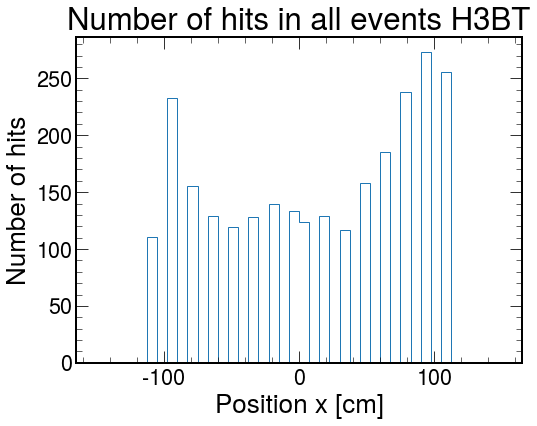

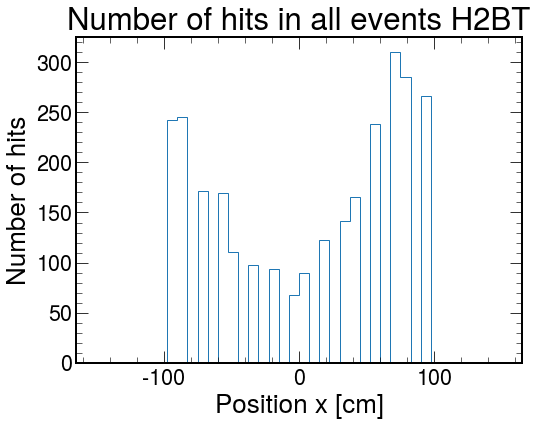

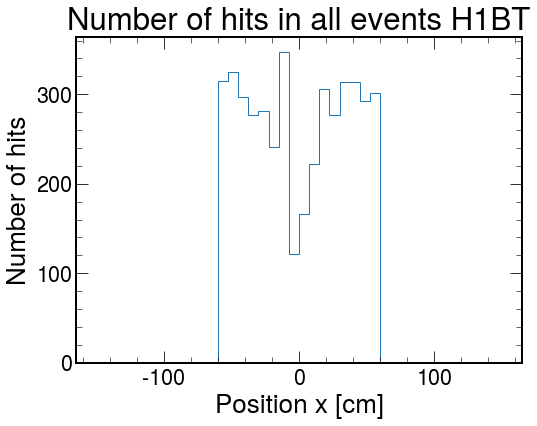

/Users/cristina/Library/Python/3.6/lib/python/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


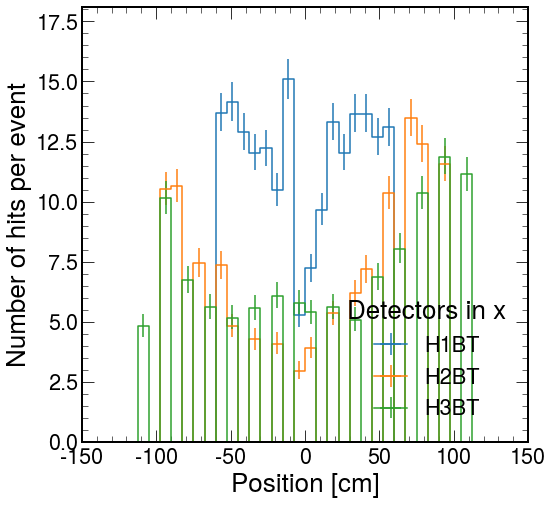

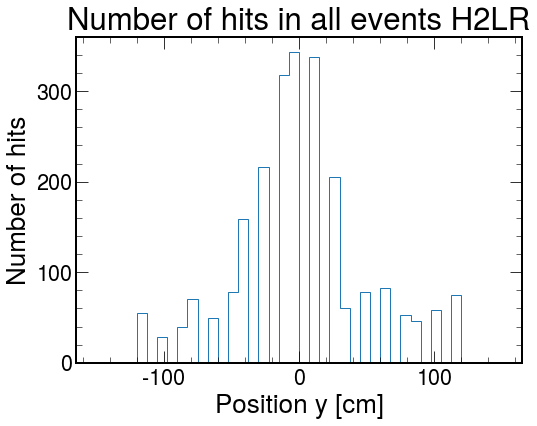

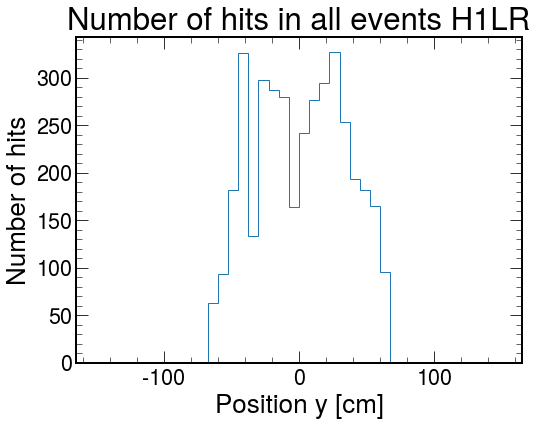

/Users/cristina/Library/Python/3.6/lib/python/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


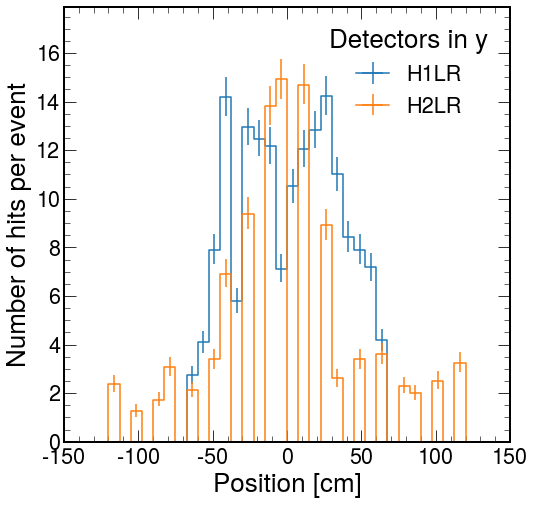

In [6]:
# mask w. triggerBits &(32|128)
trigmask = (root.fTriggerBits == 67)
trigmask = trigmask | (root.fTriggerBits == 65)

allhits = root.fAllHits
maskedhits = ak.mask(allhits,trigmask)

detmask = detectorMask(allhits)

for dets,item in detid_dict.items():
    direction = item['dir']
    detectors = item['det']
    pos_axis = hist.Bin("pos", "Position [cm]", 40, -150, 150)
    hpos = hist.Hist("Number of hits per event",hist.Cat("detector", "Detectors in %s"%direction),pos_axis)
    for det in detectors.keys():
        maskedhits_det = maskedhits[detmask[det]]
        numpos = ak.num(maskedhits_det.pos)
    
        fig = plt.figure(figsize=(8,6))
        plt.hist(ak.flatten(maskedhits_det.pos), bins=40, range=(-150,150), histtype='step', density=False)
        plt.ylabel("Number of hits")
        plt.xlabel("Position %s [cm]"%direction)
        plt.title("Number of hits in all events %s"%det)
        plt.savefig("positionNhits_%s_%s.png"%(direction,det))
        plt.show()

        nevents = len(np.array(ak.count(maskedhits_det.pos, axis=0)))

        hpos.fill(detector=det,pos=np.array(ak.flatten(maskedhits_det.pos)))
        
    hpos.scale(1/nevents)
    
    fig,ax = plt.subplots(1,1, figsize=(8,8))
    hist.plot1d(hpos, overlay='detector',ax=ax);
    fig.savefig("rate_%s.png"%dets)